###Load Data

In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=False)
%cd /content/drive/My Drive



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/
/content/drive/My Drive


In [2]:
import pandas as pd
df_healthy = pd.read_csv('result_healthy_pandas.csv', engine='python', header=None)
df_healthy.head()

,0,1,2,3
0,0,97,0.053197,0.145667
1,1,97,0.088662,0.097796
2,2,97,0.099718,0.054856
3,3,97,0.058621,0.036982
4,4,97,-0.004590,0.054445


In [3]:
import numpy
df_faulty = pd.read_csv('result_faulty_pandas.csv', engine='python', header=None)
print(numpy.shape(df_faulty))
df_faulty.head()

(488309, 4)


,0,1,2,3
0,0,105,-0.083004,-0.402075
1,1,105,-0.195734,-0.004725
2,2,105,0.233419,-0.106631
3,3,105,0.103958,-0.074169
4,4,105,-0.181115,0.208947


Check normalization

In [4]:
import numpy as np
print(np.amax(df_healthy.round(1).loc[:]))
print(np.amin(df_healthy.round(1).loc[:]))

0    1213483.0
1        100.0
2          0.3
3          0.4
dtype: float64
0     0.0
1    97.0
2    -0.3
3    -0.3
dtype: float64


In [5]:
print(np.amax(df_faulty.round(1).loc[:]))
print(np.amin(df_faulty.round(1).loc[:]))

0    488308.0
1       108.0
2         1.7
3         1.0
dtype: float64
0      0.0
1    105.0
2     -1.5
3     -1.2
dtype: float64


### Prepare Sequential

In [0]:
import numpy as np
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat


In [0]:
def get_recording(df,file_id):
    return np.array(df.sort_values(by=0, ascending=True).loc[df[1] == file_id].drop(columns = [0,1]))

def create_trimmed_recording(df,file_id,timesteps,dim):
    recording = get_recording(df,file_id) 
    samples = len(recording)
    trim = samples % 100
    trimmed = samples-trim
    recording_trimmed = recording[:trimmed]
    recording_trimmed.shape = (int((trimmed)/timesteps),timesteps,dim)
    return recording_trimmed


In [8]:
#pd.unique()
#df_healthy.drop(0,1).drop(2,1).drop(3,1)
pd.unique(df_healthy.iloc[:,1])

array([ 97,  98, 100])

### Model

In [9]:
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation
from keras.callbacks import Callback


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import time

%matplotlib inline

Using TensorFlow backend.


In [0]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

In [0]:
timesteps = 100
dim = 2
lossHistory = LossHistory()
# design network

model = Sequential()
model.add(LSTM(50,input_shape=(timesteps,dim),return_sequences=True))
model.add(Dense(2))
model.compile(loss='mae', optimizer='adam')

def train(data):
    model.fit(data, data, epochs=5, batch_size=72, validation_data=(data, data), verbose=1, shuffle=False,callbacks=[lossHistory])

def score(data):
    yhat =  model.predict(data)
    return yhat

In [17]:
file_ids = pd.unique(df_healthy.iloc[:,1])
start = time.time()
for file_id in file_ids:
    recording_trimmed = create_trimmed_recording(df_healthy,file_id,timesteps,dim)
    print("Staring training on %s" % (file_id))
    #train(recording_trimmed)
    model.fit(recording_trimmed, recording_trimmed, epochs=5, batch_size=72, validation_data=(recording_trimmed, recording_trimmed), verbose=1, shuffle=False,callbacks=[lossHistory])
    print("Finished training on %s after %s seconds" % (file_id,time.time()-start))

print("Finished job on after %s seconds" % (time.time()-start))
healthy_losses = lossHistory.losses


Staring training on 97
Train on 2439 samples, validate on 2439 samples
Epoch 1/5
2439/2439 [==============================] - 7s 3ms/step - loss: 0.0569 - val_loss: 0.0505
Epoch 2/5
2439/2439 [==============================] - 7s 3ms/step - loss: 0.0441 - val_loss: 0.0354
Epoch 3/5
2439/2439 [==============================] - 7s 3ms/step - loss: 0.0269 - val_loss: 0.0205
Epoch 4/5
2439/2439 [==============================] - 7s 3ms/step - loss: 0.0159 - val_loss: 0.0113
Epoch 5/5
2439/2439 [==============================] - 6s 3ms/step - loss: 0.0094 - val_loss: 0.0078
Finished training on 97 after 35.24387216567993 seconds
Staring training on 98
Train on 4839 samples, validate on 4839 samples
Epoch 1/5
4839/4839 [==============================] - 13s 3ms/step - loss: 0.0061 - val_loss: 0.0039
Epoch 2/5
4839/4839 [==============================] - 14s 3ms/step - loss: 0.0039 - val_loss: 0.0035
Epoch 3/5
4839/4839 [==============================] - 13s 3ms/step - loss: 0.0031 - val_loss

In [0]:
healthy_losses = lossHistory.losses

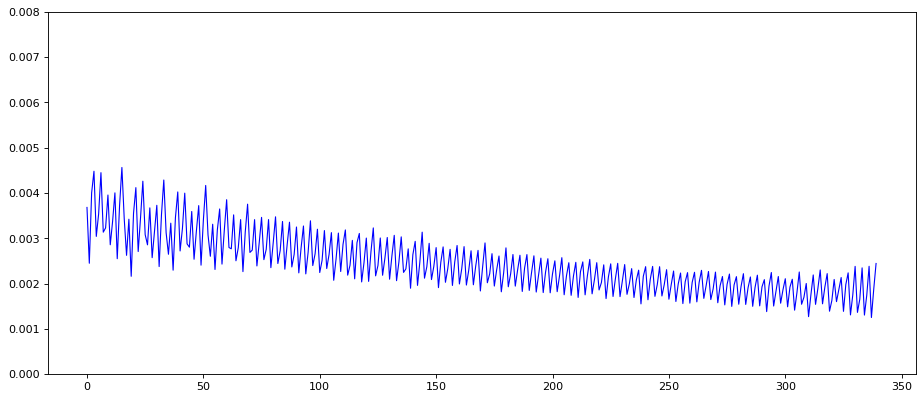

In [19]:
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(healthy_losses)
plt.ylim(0,0.008)
ax.plot(range(0,size), healthy_losses, '-', color='blue', animated = True, linewidth=1)

In [20]:
file_ids = pd.unique(df_faulty.iloc[:,1])
start = time.time()
for file_id in file_ids:
    recording_trimmed = create_trimmed_recording(df_faulty,file_id,timesteps,dim)
    print("Staring training on %s" % (file_id))
    model.fit(recording_trimmed, recording_trimmed, epochs=5, batch_size=72, validation_data=(recording_trimmed, recording_trimmed), verbose=1, shuffle=False,callbacks=[lossHistory])
    print("Finished training on %s after %s seconds" % (file_id,time.time()-start))

print("Finished job on after %s seconds" % (time.time()-start))
faulty_losses = lossHistory.losses


Staring training on 105
Train on 1212 samples, validate on 1212 samples
Epoch 1/5
1212/1212 [==============================] - 4s 3ms/step - loss: 0.0125 - val_loss: 0.0090
Epoch 2/5
1212/1212 [==============================] - 3s 3ms/step - loss: 0.0078 - val_loss: 0.0065
Epoch 3/5
1212/1212 [==============================] - 3s 3ms/step - loss: 0.0059 - val_loss: 0.0054
Epoch 4/5
1212/1212 [==============================] - 3s 3ms/step - loss: 0.0051 - val_loss: 0.0048
Epoch 5/5
1212/1212 [==============================] - 3s 3ms/step - loss: 0.0046 - val_loss: 0.0044
Finished training on 105 after 16.649536609649658 seconds
Staring training on 106
Train on 1219 samples, validate on 1219 samples
Epoch 1/5
1219/1219 [==============================] - 3s 3ms/step - loss: 0.0043 - val_loss: 0.0041
Epoch 2/5
1219/1219 [==============================] - 3s 3ms/step - loss: 0.0040 - val_loss: 0.0039
Epoch 3/5
1219/1219 [==============================] - 3s 3ms/step - loss: 0.0038 - val_los

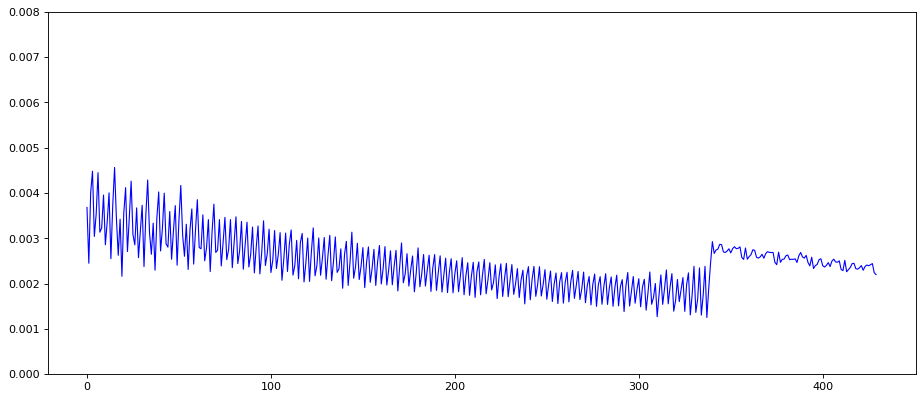

In [22]:
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(healthy_losses+faulty_losses)
plt.ylim(0,0.008)
ax.plot(range(0,size), healthy_losses+faulty_losses, '-', color='blue', animated = True, linewidth=1)